In [1]:
!pip install torchtext==0.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 1.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.7.1 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.7.1 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torchtext.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-02-21 02:32:36--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.82MB/s    in 0.3s    

2023-02-21 02:32:37 (1.82 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [5]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.columns = ['labels', 'data']

In [10]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [12]:
df2 = df[['data', 'b_labels']]

In [13]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [14]:
df2.to_csv('spam2.csv', index=False)

In [18]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=False,
    pad_first=True
)

LABEL = ttd.Field(
    sequential=False,
    use_vocab=False,
    is_target=True
)

# Note: if you don't specify use_vocab=False, then PyTorch will
# complain later when you try to iterate over the dataset that
# the attribute `vocab` doesn't exist.

# Note 2: if you don't specify is_target=True, then PyTorch will
# assume it's part of the input, so when you iterate over the
# dataset it will be like:
# for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(
    path="spam2.csv",
    format="csv",
    skip_header=True,
    fields=[("data", TEXT), ("label", LABEL)]
)

/usr/local/lib/python3.8/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.8/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [20]:
train_dataset, test_dataset = dataset.split() # default is 0.7

In [21]:
TEXT.build_vocab(train_dataset)

In [22]:
vocab = TEXT.vocab

In [24]:
vocab.stoi # sentence to indices

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fbbfad6ae80>>,
            {'<unk>': 0,
             '<pad>': 1,
             'to': 2,
             'you': 3,
             'I': 4,
             'a': 5,
             'the': 6,
             'and': 7,
             'is': 8,
             'in': 9,
             'i': 10,
             'u': 11,
             'for': 12,
             'my': 13,
             'your': 14,
             'of': 15,
             'me': 16,
             'have': 17,
             'on': 18,
             '2': 19,
             'that': 20,
             'it': 21,
             'are': 22,
             'call': 23,
             'or': 24,
             'with': 25,
             'at': 26,
             'be': 27,
             'will': 28,
             'not': 29,
             'get': 30,
             'ur': 31,
             'so': 32,
             'U': 33,
             'but': 34,
             'can': 35,
             '&lt;#&gt;': 36,
             "I'm": 37,
  

In [25]:
vocab.itos # indices to sentence

['<unk>',
 '<pad>',
 'to',
 'you',
 'I',
 'a',
 'the',
 'and',
 'is',
 'in',
 'i',
 'u',
 'for',
 'my',
 'your',
 'of',
 'me',
 'have',
 'on',
 '2',
 'that',
 'it',
 'are',
 'call',
 'or',
 'with',
 'at',
 'be',
 'will',
 'not',
 'get',
 'ur',
 'so',
 'U',
 'but',
 'can',
 '&lt;#&gt;',
 "I'm",
 '4',
 'You',
 '.',
 'from',
 'do',
 'up',
 'we',
 'go',
 'know',
 'just',
 'when',
 'if',
 'like',
 'all',
 'come',
 'this',
 'was',
 'out',
 'got',
 'now',
 '?',
 'am',
 '...',
 'about',
 'time',
 'only',
 'want',
 'by',
 'no',
 'what',
 'then',
 'send',
 'going',
 'Call',
 'If',
 'its',
 'How',
 "I'll",
 'need',
 'But',
 'still',
 'n',
 'as',
 'he',
 'our',
 'text',
 'there',
 'So',
 'one',
 'good',
 'We',
 'any',
 'No',
 'been',
 'love',
 'see',
 'back',
 'Do',
 'Just',
 'dont',
 '&',
 'has',
 'Ì_',
 'And',
 'Your',
 "don't",
 'My',
 'What',
 'home',
 'The',
 'how',
 'day',
 'free',
 'think',
 '-',
 'her',
 'later',
 'now.',
 'take',
 'tell',
 'they',
 'some',
 'who',
 'an',
 'new',
 'r',
 'A

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
train_iter, test_iter = ttd.Iterator.splits((train_dataset, test_dataset), sort_key=lambda x: len(x.data), batch_sizes=(32, 256), device=device)

/usr/local/lib/python3.8/dist-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [29]:
for inputs, targets in train_iter:
  print(f"Inputs: {inputs}, Input Shape: {inputs.shape}")
  print(f"Targets: {targets}, Target Shape: {targets.shape}")
  break

Inputs: tensor([[    1,     1,     1,  ...,     5, 10239, 11272],
        [    1,     1,     1,  ..., 11174, 11329,   510],
        [    1,     1,     1,  ...,    92,  4188,   308],
        ...,
        [    1,     1,     1,  ...,   417,   140, 11394],
        [    1,     1,     1,  ...,   267,   158,   972],
        [    1,     1,     1,  ...,    24,   759,  1125]]), Input Shape: torch.Size([32, 45])
Targets: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0]), Target Shape: torch.Size([32])


/usr/local/lib/python3.8/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [30]:
for inputs, targets in test_iter:
  print(f"Inputs: {inputs}")
  print(f"Targets: {targets}")
  break

Inputs: tensor([[    4,   294,    14,     0,     0,     0],
        [    4,    69,     6, 10855,     0,   299],
        [    0,     0,     8,     9,   170,     0],
        ...,
        [    1,     1,     1,     1,     1,  3442],
        [    1,     1,     1,     1,     1,   553],
        [    1,     1,     1,     1,     1,   920]])
Targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 

/usr/local/lib/python3.8/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [31]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )

    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)

    # get RNN unit output
    out, _ = self.rnn(out, (h0, c0))

    # max pool 
    out, _ = torch.max(out, 1)

    # we only want h(T) at the final time step
    out = self.fc(out)
    return out

In [32]:
model = RNN(len(vocab), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(12457, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [33]:
# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [37]:
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      targets = targets.view(-1, 1).float()

      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward Pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and Optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    
    train_losses[i] = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_iter:
      inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    
    test_losses[i] = np.mean(test_loss)
    dt = datetime.now() - t0
    print(f'Epoch {i+1}/{epochs}, Train Loss: {train_losses[i]:.4f}, Test Loss: {test_losses[i]:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [38]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_iter, test_iter, 15)

/usr/local/lib/python3.8/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch 1/15, Train Loss: 0.3030, Test Loss: 0.3262, Duration: 0:00:02.991810
Epoch 2/15, Train Loss: 0.2356, Test Loss: 0.3003, Duration: 0:00:02.863082
Epoch 3/15, Train Loss: 0.1680, Test Loss: 0.2169, Duration: 0:00:02.816873
Epoch 4/15, Train Loss: 0.1234, Test Loss: 0.1933, Duration: 0:00:03.767798
Epoch 5/15, Train Loss: 0.0948, Test Loss: 0.1755, Duration: 0:00:03.367174
Epoch 6/15, Train Loss: 0.0775, Test Loss: 0.1669, Duration: 0:00:02.832059
Epoch 7/15, Train Loss: 0.0647, Test Loss: 0.1536, Duration: 0:00:02.921633
Epoch 8/15, Train Loss: 0.0558, Test Loss: 0.1379, Duration: 0:00:03.347508
Epoch 9/15, Train Loss: 0.0467, Test Loss: 0.1351, Duration: 0:00:03.742461
Epoch 10/15, Train Loss: 0.0390, Test Loss: 0.1385, Duration: 0:00:02.896053
Epoch 11/15, Train Loss: 0.0346, Test Loss: 0.1233, Duration: 0:00:02.877810
Epoch 12/15, Train Loss: 0.0281, Test Loss: 0.1160, Duration: 0:00:02.827790
Epoch 13/15, Train Loss: 0.0208, Test Loss: 0.1166, Duration: 0:00:04.295442
Epoch 14

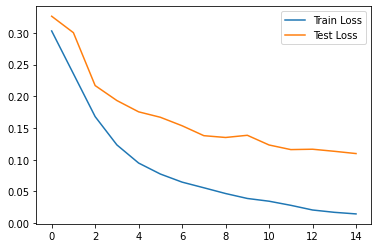

In [40]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [41]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_iter:
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

/usr/local/lib/python3.8/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Train acc: 0.9982, Test acc: 0.9635
